## CT5133 / CT5145 Deep Learning (/Online) 2022-2023

## Assignment 2

## James McDermott

* Student ID(s): 22223696
* Student name(s): Smitesh Nitin Patil

**Due date**: midnight Sunday 19 March (end Week 10).

**Weighting**: 20% of the module.

In this assignment the goal is to take advantage of pre-trained NN models to create an embedding with a dataset of movie posters, and demonstrate how to use that embedding.

The dataset is provided, along with some skeleton code for loading it.

The individual steps to be carried out are specified below, with `### YOUR CODE HERE` markers, together with the number of marks available for each part.

* **Topics**: in Part 5 below, students are asked to add some improvement to their models. In general, these improvements will differ between students (or student groups). **The proposed improvement must be notified to the lecturer at least 1 week before submission, and approved by the lecturer**. If working in a group, the two members of the group should not work on different topics in Part 5: they must work on the same topic and submit identical submissions.

* Students are not required to work incrementally on the parts. It is ok to do all the work in one day, so long as you abide by the rules on notifying groups and notifying topics.

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras/Tensorflow, or in PyTorch. 

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code (eg 1-2 lines) from the internet, **if you provide a citation with URL**. You may also use a longer snippet of code if it is a utility function, again only with citation. You may not use code from the internet to carry out the core of the assignment. You may not use a large language model to generate code.

* **Submission**: after completing your work in this Jupyter notebook, submit the notebook both in `.ipynb` and `.pdf` formats. The content should be identical.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.


### Dataset Credits

The original csv file is from: 

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

I have added the *year* column for convenience.

I believe most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/

However, I'm not clear whether the poster download URLs (Amazon AWS URLs) which are in the csv obtained from the Kaggle URL above are from a MovieLens source, or elsewhere.

To create the dataset we are using, I have randomly sampled a small proportion of the URLs in the csv, and downloaded the images. I have removed those which fail to download. Code below also filters out those which are in black and white, ie 1 channel only.

### Imports

You can add more imports if needed.

In [2]:
import numpy as np
import pandas as pd
import math
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding

In [3]:
import tensorflow as tf
import torch
from tensorflow import keras
from keras import layers, models
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.vgg16 import preprocess_input
from keras.layers import Flatten, Dense, Embedding, GlobalAveragePooling2D
from keras.models import Model


import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

C:\Users\Smitesh\anaconda3\envs\Main\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Utility functions

These functions are provided to save you time. You might not need to understand any of the details here.

In [4]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk('DL_Sample'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

This is 1 channel, so we omit it (268, 182) 290031.jpg
This is 1 channel, so we omit it (268, 182) 294266.jpg
This is 1 channel, so we omit it (268, 182) 30337.jpg
This is 1 channel, so we omit it (268, 182) 3626440.jpg
This is 1 channel, so we omit it (268, 182) 50192.jpg
This is 1 channel, so we omit it (268, 182) 54880.jpg
This is 1 channel, so we omit it (268, 182) 57006.jpg


In [5]:
img_array = np.array(images)

In [6]:
img_array.shape

(1254, 268, 182, 3)

In [7]:
# read the csv
df = pd.read_csv("Movie_Genre_Year_Poster.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,1995.0
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,1995.0
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0


In [8]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [9]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [10]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [11]:
df4.shape # 1254 rows matches the image data shape above

(1254, 6)

In [12]:
years = df4["Year"].values
titles = df4["Title"].values

assert img_array.shape[0] == years.shape[0] == titles.shape[0]

In [13]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """
    
    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"DL_Sample/{filename}.jpg"
        
    # now we can assume it's a filename, so open and read
    im = Image.open(filename)
    
    return im

def imshow(im):
    plt.imshow(im)
    plt.axis('off')
    plt.show()

### Part 1. Create embedding [3 marks]

Use a pretrained model, eg as provided by Keras, to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and put all of these together into a single tensor of shape `(n_movies, embedding_size)`.

In [15]:
#initialising processed_image array for storing the preprocessed inputs
processed_images = []
n_movies = np.array(df4.index)

#processing all images before feeding them to network to create embeddings
for image in img_array:
    #image = image/255.0
    processed_images.append(preprocess_input(image))

#inilialialising network architecture by removing the dense and output layer 
#model = VGG16(include_top=False, input_shape= img_array[0].shape)
model = VGG19(include_top = False, input_shape = img_array[0].shape, weights="imagenet")

#setting the layers as not trainable as we are not training our model just creating embeddings
for layer in model.layers:
    layer.trainable = False

# appending a flatten layer that would be the output the embeddings created would be of size of dimension of images
x =  model.output
predictions = Flatten()(x)

# initialising the model with the architecture created
model = Model(inputs = model.input, outputs = predictions)
model.summary()

#creating embeddings
out = model.predict(np.array(processed_images))

80134624/80134624 [==============================] - 7s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 268, 182, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 268, 182, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 268, 182, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 134, 91, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 134, 91, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 134, 91, 128)      147584    
                                                            

In [16]:
#creating final tensor with the embeddings and their respective IDS
X = torch.cat((torch.tensor(out), torch.tensor(IDs).unsqueeze(dim=1)), dim=1)
assert len(X.shape) == 2 # X should be (n_movies, embedding_size)
assert X.shape[0] == len(n_movies)

### Part 2. Define a nearest-neighbour function [3 marks]

Write a function `def nearest(img, k)` which accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity. 

In [17]:
# function to get k posters most similar to the input image
def k_nearest(img_id, k):
    # getting the index from the previous X tensor
    index = X[:, -1]
    # getting the embeddings generated
    vector_embeddings = X[:, :(len(X[0])-1)]
    
    #getting the embedding of the input image
    image_embedding = [vector_embeddings[i] for i, idx in enumerate(index) if img_id == int(idx)]
    #initialising the cosime_similarity list
    cosine_similarities = []
    #looping through all the embeddings
    for idx, embeddings in enumerate(vector_embeddings):
        #getting the similarity value between each embedding and image embedding
        similarity = cosine_similarity(embeddings.reshape(1,-1), image_embedding[0].reshape(1, -1))
        cosine_similarities.append(similarity)
    
    # getting the idx of images with cosine similarity among top 1:k+1 values
    similar_images = [int(idx) for i, idx in enumerate(index) if cosine_similarities[i] in sorted(cosine_similarities, 
                                                                                                  reverse = True)[1:k+1]]
    
    print(len(similar_images))
    
    #orginial image
    print("Image")
    imshow(imread(img_id))
    
    #similar images found
    print("Similar Images")
    for img in similar_images:
        imshow(imread(img))
    
    # score of similar images
    print("Image Scores: ", sorted(cosine_similarities, reverse = True)[1:k+1])
        

### Part 3: Demonstrate your nearest-neighbour function [4 marks]

Choose any movie poster. Call this the query poster. Show it, and use your nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself). This means **call** the function you defined above.

Write a comment: in what ways are they similar or dissimilar? Do you agree with the choice and the ranking? Why do you think they are close in the embedding? Do you notice, for example, that the nearest neighbours are from a similar era? 


5
Image


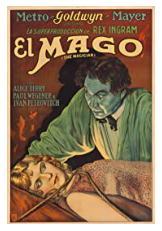

Similar Images


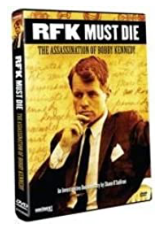

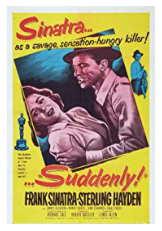

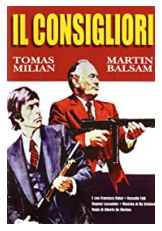

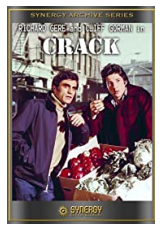

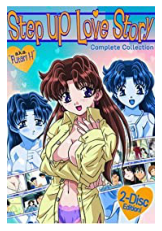

Image Scores:  [array([[0.32242334]], dtype=float32), array([[0.29644692]], dtype=float32), array([[0.28950587]], dtype=float32), array([[0.28663203]], dtype=float32), array([[0.27021962]], dtype=float32)]


In [18]:
### YOUR code HERE
Q_idx = 17103 # YOUR VALUE HERE - DO NOT USE MY VALUE

k_nearest(Q_idx, 5)

### Part 4: Year regression [5 marks]

Let's investigate the last question ("similar era") above by running **regression** on the year, ie attempt to predict the year, given the poster. Use a train-test split. Build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. Include comments to explain the purpose of each part of the model. It should be possible to make a prediction, given a new poster (not part of the original dataset). Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

In [19]:
#dropping the index
df4 = df4.reset_index()
#selecting the title and year
df4 = df4[['Title', 'Year']]

In [20]:
#checking if year has any null values
df4['Year'].isna().value_counts()

False    1238
True       16
Name: Year, dtype: int64

In [21]:
#getting the index of null values
index = df4['Year'].index[df4['Year'].apply(np.isnan)]

In [22]:
df4.iloc[index]

,Title,Year
93,XIII: The Conspiracy,NaN
152,The Last Templar,NaN
189,Carlos,NaN
240,In Two Minds,NaN
290,The Hallelujah Handshake,NaN
359,Dragon Age: Redemption,NaN
416,Black Mirror,NaN
475,The Dust Bowl,NaN
673,And Then There Were None,NaN
683,10.5,NaN


In [23]:
#droping the indexed value that are NaN
df4 = df4.drop(index)

In [24]:
# getting embeddings and removing embeddings for which we dont have year data
embeddings = [arr for i, arr in enumerate(X[:, :(len(X[0])-1)]) if i not in index]

In [25]:
# checking if the len of img_data and yers are equal
assert len(embeddings) == len(df4)

In [26]:
# appending img_data in dataframe for subsetting
df4['embedding'] = embeddings

In [27]:
from sklearn.model_selection import train_test_split

# subsetting data into train 70%, test 15%, val 15%
train_df, test_df = train_test_split(df4, train_size=0.7, shuffle=True, random_state=1)
test_df, val_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=1)

In [28]:
X_train = np.array([t.numpy() for t in train_df['embedding']])
y_train = np.array([int(t) for t in train_df['Year']])
X_val = np.array([t.numpy() for t in val_df['embedding']])
y_val = np.array([int(t) for t in val_df['Year']])
X_test = np.array([t.numpy() for t in test_df['embedding']])
y_test = np.array([int(t) for t in test_df['Year']])

assert(len(X_train) == len(y_train))
assert(len(X_val) == len(y_val))
assert(len(X_test) == len(y_test))

In [44]:
from keras.optimizers import Adam, SGD
from keras.models import Sequential
# inilialising the model
model = Sequential([
    Dense(20192, input_shape = (X_train[0].shape[0], ), activation = "relu"),
    Dense(1024, activation = "relu"),
    Dense(256, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(1, activation = 'linear')
])

# Compile the model
model.compile(optimizer = Adam(1e-6), loss='mse')

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 20192)             413552352 
                                                                 
 dense_41 (Dense)            (None, 1024)              20677632  
                                                                 
 dense_42 (Dense)            (None, 256)               262400    
                                                                 
 dense_43 (Dense)            (None, 128)               32896     
                                                                 
 dense_44 (Dense)            (None, 1)                 129       
                                                                 
Total params: 434,525,409
Trainable params: 434,525,409
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model training with 20 epochs and stopping early if validation loss increases for 5 consecutive epochs
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 100, 
         callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ])

Epoch 1/100
 7/28 [======>.......................] - ETA: 40s - loss: 3930368.0000

In [ ]:
# predictions
predictions = model.predict(X_test)

In [ ]:
# Root mean squared value for accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.sqrt(mean_squared_error(predictions, y_test))

In [ ]:
predictions = [np.mean(y_test)] * len(y_test)
np.sqrt(mean_squared_error(predictions, y_test))

# Load Images

### Part 5: Improvements [5 marks]

Propose a possible improvement. Some ideas are suggested below. The chosen improvement must be notified to the lecturer at least 1 week before submission and **must be approved by the lecturer to avoid duplication with other students**. Compare the performance between your original and your new model (the proposed improvement might not actually improve on model performance -- that is ok). Some marks will be awarded for more interesting / challenging / novel improvements.

Ideas:

* Try a different pretrained model for creating the embedding
* Alternative ways of reducing the pretrained model's output to a flat vector for the embedding
* Gather more data (see the csv file for URLs)
* Add different architectural details to the regression head
* Fine-tuning
* Training an end-to-end convnet of your own design (no pretraining)
* Improve the embedding by training a multi-headed model, eg predicting both genre and year
* Create a good visualisation of the embedding.


In [ ]:
### YOUR CODE HERE
#subsetting image url and year
df_5 = df[['imdbId', 'Poster', 'Year']]

In [ ]:
#dropping all null values and reconfirming
df_5 = df_5.dropna()
df_5.isna().value_counts()

In [ ]:
"""
import os
import sys
os.chdir(os.getcwd())

#downloading images and storing them as their respective imdbId.jpg
import requests
i = 1
for img_url, imdbId in zip(df_5['Poster'], df_5['imdbId']):
    total = len(df_5)
    img_data = requests.get(img_url).content
    imdbPresent = []
    #only gettings images for status code found
    if requests.get(img_url).status_code == 200:
        with open(str(imdbId)+'.jpg', 'wb') as handler:
            i =  i+1
            handler.write(img_data)
        imdbPresent.append(imdbId)
        sys.stdout.write("\rImages Done: " + str(i))
        sys.stdout.flush()
"""

In [ ]:
import glob
import re

Ids = [int(re.sub("[^0-9]", "",file)) for file in glob.glob("task_images//*.jpg")]
images = [np.array(Image.open(file), dtype=float) for file in glob.glob("task_images//*.jpg")]

In [ ]:
years = []
for idx in Ids:
    

In [ ]:
train_df, test_df = train_test_split(df_5, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Poster',
    y_col='Year',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Poster',
    y_col='Year',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Poster',
    y_col='Year',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)